# 年別

In [1]:
import pandas as pd
import numpy as np
import re
import os, sys
import matplotlib.pyplot as plt
import seaborn as sns
from collections import Counter, defaultdict
from itertools import product
from scipy import stats

%matplotlib inline
plt.style.use('ggplot')
#plt.style.use('seaborn-pastel')
%config InlineBackend.figure_format = 'retina'
import warnings
warnings.filterwarnings('ignore')
from tqdm import tqdm_notebook as tq

sys.path.append("..")
from utils.util_functions import *

pd.set_option('display.max_rows', 500)

In [2]:
#event_df = make_df(data_dir=DETAIL_DATA_DIR_MLB)
#event_df = pd.read_csv(os.path.join(ROOT_DIR, "event_df.csv"), index_col=0, encoding="cp932", dtype=object)
#df_2017 = make_df(end=1944417, data_dir=DETAIL_DATA_DIR_MLB)
#df_2017 = pd.read_csv(os.path.join(ROOT_DIR, "df_2017.csv"), index_col=0, encoding="cp932", dtype=object)
#df_2018 = make_df(start=1944417, data_dir=DETAIL_DATA_DIR_MLB)
#df_2018 = pd.read_csv(os.path.join(ROOT_DIR, "df_2018.csv"), index_col=0, encoding="cp932", dtype=object)
files = os.listdir(DETAIL_DATA_DIR_MLB)[1:]
names = pd.Series(files).apply(lambda x: int(x.split(".")[0]))
files_2017 = names[names<=1944417].apply(lambda x: str(x)+".csv")
files_2018 = names[names>1944417].apply(lambda x: str(x)+".csv")
column = "得点"
teams_mlb = list(set(pd.read_csv(os.path.join(SCORE_DATA_DIR_MLB, "score_mlb.csv"), encoding="cp932", index_col=0).表チーム))
teams_mlb.remove("ア・リーグ")
first_teams = ['Rソックス', 'インディアンス', 'アストロズ', 'ブレーブス', 'ブリュワーズ', 'ドジャース']
second_teams = ['ヤンキース', 'ツインズ', 'アスレチックス', 'ナショナルズ', 'カブス', 'ロッキーズ']
third_teams = ['レイズ', 'タイガース', 'マリナーズ', 'フィリーズ', 'カージナルス', 'Dバックス']
fourth_teams = ['ブルージェイズ', 'Wソックス',  'エンゼルス', 'メッツ', 'パイレーツ', 'ジャイアンツ']
fifth_teams = ['オリオールズ', 'ロイヤルズ', 'レンジャーズ', 'マーリンズ', 'レッズ', 'パドレス']

In [3]:
#event_df.to_csv(os.path.join(ROOT_DIR, "event_df.csv"), encoding="cp932")
#df_2017.to_csv(os.path.join(ROOT_DIR, "df_2017.csv"), encoding="cp932")
#df_2018.to_csv(os.path.join(ROOT_DIR, "df_2018.csv"), encoding="cp932")

In [4]:
def ranking(team):
    first_teams = ['Rソックス', 'インディアンス', 'アストロズ', 'ブレーブス', 'ブリュワーズ', 'ドジャース']
    second_teams = ['ヤンキース', 'ツインズ', 'アスレチックス', 'ナショナルズ', 'カブス', 'ロッキーズ']
    third_teams = ['レイズ', 'タイガース', 'マリナーズ', 'フィリーズ', 'カージナルス', 'Dバックス']
    fourth_teams = ['ブルージェイズ', 'Wソックス',  'エンゼルス', 'メッツ', 'パイレーツ', 'ジャイアンツ']
    fifth_teams = ['オリオールズ', 'ロイヤルズ', 'レンジャーズ', 'マーリンズ', 'レッズ', 'パドレス']
    lst = [first_teams, second_teams, third_teams, fourth_teams, fifth_teams]
    for i in range(len(lst)):
        teams = lst[i]
        if team in teams:
            return i + 1

In [5]:
case_expected_score_dict = dict(pd.read_csv(os.path.join(ROOT_DIR, "case_expected_score.csv"), dtype=object).values)
case_expected_score_dict = dict([[key, float(value)] for key, value in case_expected_score_dict.items()])

def weighted_score(case, score):
    """
    lst : (Stの状況, 直後の得点)
    """
    return score / case_expected_score_dict[case]

In [ ]:
case_expected_score_dict

In [ ]:
team = "Rソックス"
"""df = event_df[event_df.攻撃チーム==team]
triple = make_inning_triple(make_inning_list(df, score_end=1, how="both"))
lst = make_flattened_list(triple)"""

In [ ]:
def triple_on_score_diff(team, diff_lower, diff_upper, year="both"):
    if year == "both":
        df = event_df[event_df.攻撃チーム==team]
    elif int(year) == 2018:
        df = df_2018[df_2018.攻撃チーム==team]
    elif int(year) == 2017:
        df = df_2017[df_2017.攻撃チーム==team]
    triple = make_inning_triple(make_inning_list(df, score_end=1, how="both"))
    lst = make_flattened_list(triple)
    res = []
    for elem in lst:
        my_score = int(elem[1][1])
        opp_score = int(elem[1][2])
        if diff_lower < diff_upper:
            if diff_lower <= my_score - opp_score <= diff_upper:
                res.append(((elem[0][0], elem[0][1]), (elem[1][0], elem[1][1]), (elem[2][0], elem[2][1])))
        elif diff_lower > diff_upper:
            if diff_lower <= my_score - opp_score or my_score - opp_score <= diff_upper:
                res.append(((elem[0][0], elem[0][1]), (elem[1][0], elem[1][1]), (elem[2][0], elem[2][1])))
        else:
            raise "diff_lower == diff_upper"
    return res

## positive inhibition = 勝ってるから気をぬく = 流れはいいのに点が取れない

## positive inhibitionを起こしがちなチームは、大差がつくとimp時の期待得点が下がる

# 点数気にしない

In [6]:
#imp_list = []
#det_list = []
res_dict1 = dict()
for team in teams_mlb:
    df = df_2018[df_2018.攻撃チーム==team]
    triple = make_inning_triple(make_inning_list(df, score_end=1, how="own"))
    lst = make_flattened_list(triple[:])
    improved_score_list = []
    deteriorated_score_list = []
    for three_series in [elem for elem in lst if elem[0][0]!="3000" and elem[1][0]!="3000"]:
        if is_improved(three_series[0][0], three_series[1][0]):
            improved_score_list.append(weighted_score(three_series[1][0], three_series[2][1]-three_series[1][1]))
        elif is_deteriorated(three_series[0][0], three_series[1][0]):
            deteriorated_score_list.append(weighted_score(three_series[1][0], three_series[2][1]-three_series[1][1]))
    #imp_list.append(np.mean(improved_score_list))
    #det_list.append(np.mean(deteriorated_score_list))
    res_dict1[team] = (np.mean(improved_score_list), np.mean(deteriorated_score_list))
    print(team, np.mean(improved_score_list), np.mean(deteriorated_score_list))

アスレチックス 0.95909810695 1.10230609272
アストロズ 0.975676478091 0.971769565515
パドレス 0.806578623402 0.916007573781
レンジャーズ 0.924122079791 0.888645221556
エンゼルス 0.901477934893 1.08430224374
カージナルス 0.972290897371 0.830193910803
ジャイアンツ 0.725696647321 0.544644867159
インディアンス 1.00784827106 0.990169525977
Wソックス 0.904289744233 0.912657900919
Rソックス 0.911386576467 0.93712167959
ロッキーズ 1.03728886145 1.00270883411
Dバックス 1.03161366753 0.860837069788
オリオールズ 0.906042824138 0.927070766562
ブリュワーズ 1.00623017262 0.876985729082
ブルージェイズ 0.862896392348 1.10031556848
マーリンズ 0.844679912666 0.695222098839
ロイヤルズ 0.956856578375 0.727179229931
フィリーズ 0.826993336306 0.790274289458
ドジャース 0.95392781831 1.01388431451
メッツ 0.871277001881 0.827844631927
ヤンキース 1.16128542128 1.13685642867
ブレーブス 0.951047796162 0.744919713476
パイレーツ 0.936734831758 0.704679339415
レイズ 0.712193565687 0.775499011988
マリナーズ 0.905468816839 0.844746346979
ツインズ 0.921116825618 0.886260549805
カブス 0.800344989279 0.685855024942
レッズ 0.840547854415 0.714499284529
タイガース

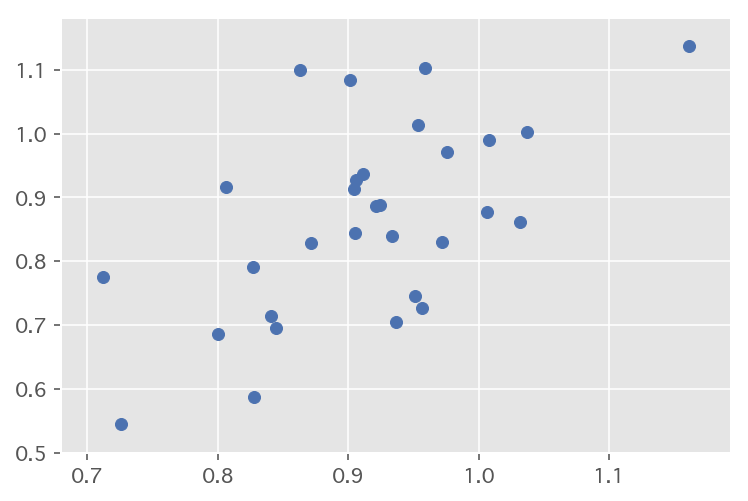

In [7]:
plt.scatter([elem[0] for elem in list(res_dict1.values())], [elem[1] for elem in list(res_dict1.values())])

# n点差以上

In [8]:
lst = triple_on_score_diff("オリオールズ", 5, 30, 2018)
improved_score_list = []
deteriorated_score_list = []
l = []
for three_series in [elem for elem in lst if elem[0][0]!="3000" and elem[1][0]!="3000"]:
    if is_improved(three_series[0][0], three_series[1][0]):
        #print(three_series)
        #break
        l.append(three_series[1][0])
        improved_score_list.append(weighted_score(three_series[1][0], three_series[2][1]-three_series[1][1]))
    elif is_deteriorated(three_series[0][0], three_series[1][0]):
        deteriorated_score_list.append(weighted_score(three_series[1][0], three_series[2][1]-three_series[1][1]))

In [9]:
#improved_score_list

In [10]:
df_2018[df_2018.攻撃チーム=="オリオールズ"]

,状況,打順,打者,結果,アウト,裏得点,表得点,イニング,表裏,攻撃チーム,file
903,0000,1,ベッカム,中安打,0,0,3,1,裏,オリオールズ,1959982.csv
904,0100,2,マチャド,三ゴロ併殺,2,0,3,1,裏,オリオールズ,1959982.csv
905,2000,3,スクープ,中フライ,3,0,3,1,裏,オリオールズ,1959982.csv
906,3000,1,NaN,NaN,NaN,0,3,1,裏,オリオールズ,NaN
913,0000,4,Aジョーンズ,遊安打,0,0,3,2,裏,オリオールズ,1959982.csv
914,0100,5,マンシーニ,空振り三振,1,0,3,2,裏,オリオールズ,1959982.csv
915,1100,6,デービス,空振り三振,2,0,3,2,裏,オリオールズ,1959982.csv
916,2100,7,トランボ,右フライ,3,0,3,2,裏,オリオールズ,1959982.csv
917,3000,2,NaN,NaN,NaN,0,3,2,裏,オリオールズ,NaN
925,0000,8,スミス,一ゴロ,1,0,5,3,裏,オリオールズ,1959982.csv


In [11]:
[elem for elem in lst if elem[0][0]!="3000" and elem[1][0]!="3000"][4]

(('1000', 6), ('1100', 6), ('1110', 6))

In [12]:
#imp_list = []
#det_list = []
res_dict = dict()
for team in teams_mlb:
    lst = triple_on_score_diff(team, 5, 30, 2018)
    improved_score_list = []
    deteriorated_score_list = []
    for three_series in [elem for elem in lst if elem[0][0]!="3000" and elem[1][0]!="3000"]:
        if is_improved(three_series[0][0], three_series[1][0]):
            improved_score_list.append(weighted_score(three_series[1][0], three_series[2][1]-three_series[1][1]))
        elif is_deteriorated(three_series[0][0], three_series[1][0]):
            deteriorated_score_list.append(weighted_score(three_series[1][0], three_series[2][1]-three_series[1][1]))
    #imp_list.append(np.mean(improved_score_list))
    #det_list.append(np.mean(deteriorated_score_list))
    res_dict[team] = (np.mean(improved_score_list), np.mean(deteriorated_score_list))
    print(team, np.mean(improved_score_list), np.mean(deteriorated_score_list))

アスレチックス 1.13117744818 1.16419633249
アストロズ 1.32824561377 1.18341653946
パドレス 1.33723839407 0.115599343186
レンジャーズ 1.09151032075 1.06231541509
エンゼルス 1.27451107754 0.957858171622
カージナルス 1.13705838928 0.549410678239
ジャイアンツ 0.338439682006 0.135177166924
インディアンス 1.22981467872 0.93641539329
Wソックス 0.444761884413 1.00662842995
Rソックス 0.985992527215 0.758461793031
ロッキーズ 1.36038375576 0.960828776533
Dバックス 1.03450666819 0.920743454476
オリオールズ 1.1846239899 0.780305705339
ブリュワーズ 1.58642508932 0.777703743431
ブルージェイズ 1.03542605716 1.3302418404
マーリンズ 0.700923957034 1.08062800621
ロイヤルズ 1.11759281891 0.767212064932
フィリーズ 1.01551089063 0.613759582109
ドジャース 1.17969624464 0.681225002322
メッツ 0.957654070804 1.76074021473
ヤンキース 1.10653432507 1.38644145991
ブレーブス 1.10563162536 0.342360571532
パイレーツ 0.712629822075 0.912124827695
レイズ 0.538460482904 1.27985909543
マリナーズ 0.721077773673 1.07178938801
ツインズ 0.529512539519 0.709330955499
カブス 0.989927405211 0.343154389371
レッズ 0.3335870472 0.3702131561
タイガース 0.363934544066 0.24

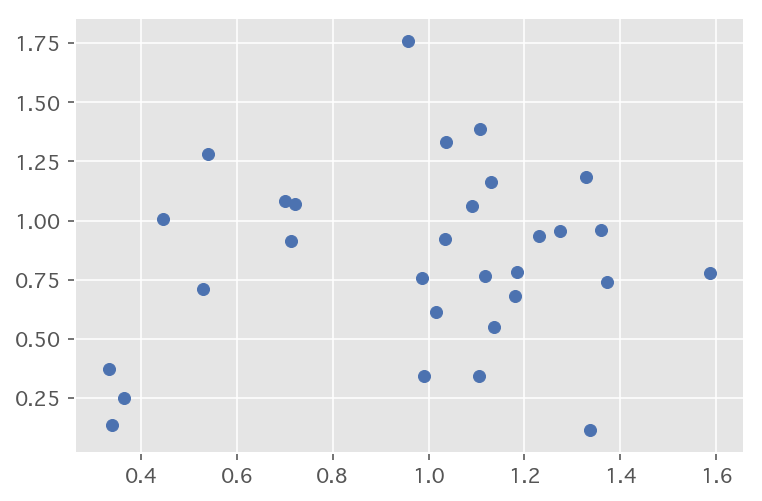

In [13]:
plt.scatter([elem[0] for elem in list(res_dict.values())], [elem[1] for elem in list(res_dict.values())])

In [14]:
# 大差で勝っていると流れがいいとボコボコにするチーム
for team in teams_mlb:
    if res_dict1[team][0] < res_dict[team][0]:
        print(ranking(team), team, res_dict[team][0] - res_dict1[team][0])

2 アスレチックス 0.17207934123
1 アストロズ 0.35256913568
5 パドレス 0.530659770664
5 レンジャーズ 0.167388240958
4 エンゼルス 0.373033142647
3 カージナルス 0.164767491911
1 インディアンス 0.221966407656
1 Rソックス 0.0746059507482
2 ロッキーズ 0.323094894312
3 Dバックス 0.00289300066367
5 オリオールズ 0.278581165766
1 ブリュワーズ 0.580194916696
4 ブルージェイズ 0.172529664811
5 ロイヤルズ 0.160736240536
3 フィリーズ 0.18851755432
1 ドジャース 0.225768426326
4 メッツ 0.0863770689232
1 ブレーブス 0.1545838292
2 カブス 0.189582415932
2 ナショナルズ 0.438096901943


In [15]:
# 大差で勝っていると油断するチーム
for team in teams_mlb:
    if res_dict1[team][0] > res_dict[team][0]:
        print(ranking(team), team, res_dict[team][0] - res_dict1[team][0])

4 ジャイアンツ -0.387256965315
4 Wソックス -0.45952785982
5 マーリンズ -0.143755955632
2 ヤンキース -0.0547510962096
4 パイレーツ -0.224105009683
3 レイズ -0.173733082783
3 マリナーズ -0.184391043167
2 ツインズ -0.391604286099
5 レッズ -0.506960807214
3 タイガース -0.463794692231
